Adınız:  Umutcan

Soyadınız:  Kemahlı

Okul Numaranız:  2212721050

GitHub Repo Bağlantısı: https://github.com/umutckem/CNN_siniflandirma.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TensorFlow kütüphanesi (derin öğrenme altyapısı)
import tensorflow as tf

# Görüntüleri diskten okuyup modele uygun hale getirmek için
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageNet üzerinde önceden eğitilmiş VGG16 mimarisi
from tensorflow.keras.applications import VGG16

# Modeli katman katman oluşturmak için
from tensorflow.keras.models import Sequential

# Modelde kullanılacak katmanlar
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

# Optimizasyon algoritması (transfer learning için yaygın)
from tensorflow.keras.optimizers import Adam

# Eğitim sürecini görselleştirmek için
import matplotlib.pyplot as plt


# =======================
# DATASET DİZİN YOLLARI
# =======================

# Eğitim verilerinin bulunduğu klasör yolu
train_dir = "/content/drive/MyDrive/Dersler/Makine-Ogrenmesi/Odev/Uygulama-1/DataSet/train"

# Doğrulama (validation) verilerinin bulunduğu klasör yolu
val_dir   = "/content/drive/MyDrive/Dersler/Makine-Ogrenmesi/Odev/Uygulama-1/DataSet/val"

# Test verilerinin bulunduğu klasör yolu
test_dir  = "/content/drive/MyDrive/Dersler/Makine-Ogrenmesi/Odev/Uygulama-1/DataSet/test"


# =======================
# MODEL VE VERİ PARAMETRELERİ
# =======================

# Modele verilecek görüntülerin yeniden boyutlandırılacağı ölçü (128x128)
IMG_SIZE = 128

# Modelin her adımda işleyeceği görüntü sayısı
BATCH_SIZE = 32


In [ ]:
# =======================
# VERİ ÖN İŞLEME (DATA PREPROCESSING)
# =======================

# Eğitim verileri için ImageDataGenerator
# Piksel değerleri 0-255 aralığından 0-1 aralığına normalize edilir
train_gen = ImageDataGenerator(rescale=1/255)

# Doğrulama verileri için ImageDataGenerator
# Eğitim ile aynı ön işleme adımları uygulanır
val_gen   = ImageDataGenerator(rescale=1/255)

# Test verileri için ImageDataGenerator
# Modelin gerçek performansını ölçmek için kullanılır
test_gen  = ImageDataGenerator(rescale=1/255)


# =======================
# EĞİTİM VERİSİNİN YÜKLENMESİ
# =======================

# Eğitim görüntüleri klasör yapısına göre okunur
# Tüm görüntüler 128x128 boyutuna getirilir
# Batch batch modele aktarılır
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


# =======================
# DOĞRULAMA VERİSİNİN YÜKLENMESİ
# =======================

# Doğrulama verisi, eğitim sırasında performans ölçümü için kullanılır
# Model bu veriler üzerinde öğrenme yapmaz
val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


# =======================
# TEST VERİSİNİN YÜKLENMESİ
# =======================

# Test verisi, eğitim tamamlandıktan sonra
# modelin genelleme yeteneğini ölçmek için kullanılır
# shuffle=False ile veri sırası korunur
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 90 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


Bu çalışmada, görüntü sınıflandırma problemi için
ImageNet veri seti üzerinde önceden eğitilmiş VGG16 mimarisi
kullanılmıştır.


Model sıfırdan eğitilmemiş, transfer learning yaklaşımı
benimsenmiştir. VGG16 modelinin tüm konvolüsyon katmanları
dondurulmuş, yalnızca sonuna eklenen tam bağlantılı
katmanlar eğitilmiştir.


Bu sayede önceden öğrenilmiş görsel özelliklerden
faydalanılarak daha hızlı ve etkili bir eğitim sağlanmıştır.


In [ ]:
# =======================
# BASE MODEL (VGG16) – TRANSFER LEARNING
# =======================

# ImageNet veri seti üzerinde önceden eğitilmiş VGG16 modeli yüklenir
# include_top=False ile VGG16'nın kendi sınıflandırma katmanları çıkarılır
# input_shape ile modele verilecek görüntü boyutu belirlenir
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128,128,3)
)

# Önceden eğitilmiş VGG16 modelinin tüm katmanları dondurulur
# Bu sayede konvolüsyonel katmanlardaki ağırlıklar güncellenmez
# Transfer learning kapsamında sadece eklenen katmanlar eğitilecektir
for layer in base_model.layers:
    layer.trainable = False


# =======================
# SINIFLANDIRICI MODEL (CUSTOM CLASSIFIER)
# =======================

# VGG16 taban modelinin üzerine özel sınıflandırma katmanları eklenir
model = Sequential([
    # Önceden eğitilmiş VGG16 taban model
    base_model,

    # Özellik haritalarını tek boyutlu vektöre dönüştürür
    Flatten(),

    # Tam bağlantılı katman – yüksek seviye özelliklerin öğrenilmesi
    Dense(512, activation='relu'),
    BatchNormalization(),  # Öğrenme sürecini stabilize eder
    Dropout(0.5),          # Overfitting'i azaltmak için

    # İkinci tam bağlantılı katman
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Üçüncü tam bağlantılı katman
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Çıkış katmanı – ikili sınıflandırma için sigmoid aktivasyonu
    Dense(1, activation='sigmoid')
])


# =======================
# MODELİN DERLENMESİ
# =======================

# Model, transfer learning için uygun düşük öğrenme oranı ile derlenir
# binary_crossentropy: ikili sınıflandırma problemleri için standart kayıp fonksiyonu
# accuracy: performans metriği
model.compile(
    optimizer=Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


# =======================
# MODEL ÖZETİ
# =======================

# Model mimarisini ve parametre sayılarını ekrana yazdırır
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,060,673 (72.71 MB)

 Trainable params: 4,344,321 (16.57 MB)

 Non-trainable params: 14,716,352 (56.14 MB)

Model, ImageDataGenerator ile oluşturulan eğitim verisi
kullanılarak 10 epoch boyunca eğitilmiştir. Eğitim sırasında
her epoch sonunda doğrulama verisi üzerinde performans ölçümü
yapılmıştır.


Önceden eğitilmiş VGG16 modelinin konvolüsyon katmanları
dondurulmuş, yalnızca son katmanlar eğitilmiştir. Bu yaklaşım,
transfer learning kapsamında özellik çıkarımı (feature
extraction) olarak adlandırılmaktadır.


In [ ]:
# =======================
# MODELİN EĞİTİLMESİ
# =======================

# Model, eğitim verileri kullanılarak belirlenen epoch sayısı boyunca eğitilir
# Her epoch sonunda doğrulama (validation) verisi ile modelin performansı ölçülür
# Önceden eğitilmiş VGG16 katmanları dondurulduğu için
# yalnızca eklenen tam bağlantılı katmanların ağırlıkları güncellenir
history = model.fit(
    train_data,           # Eğitim verileri
    epochs=10,            # Eğitim tekrar sayısı
    validation_data=val_data  # Doğrulama verileri
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.5978 - loss: 0.8300 - val_accuracy: 0.5000 - val_loss: 0.6600
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6570 - loss: 0.6017 - val_accuracy: 0.5500 - val_loss: 0.6246
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7900 - loss: 0.4288 - val_accuracy: 0.6500 - val_loss: 0.5970
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.8510 - loss: 0.3666 - val_accuracy: 0.7000 - val_loss: 0.5671
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8118 - loss: 0.3577 - val_accuracy: 0.7500 - val_loss: 0.5370
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8914 - loss: 0.2911 - val_accuracy: 0.8500 - val_loss: 0.5130
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9293 - loss: 0.2382 - val_accuracy: 0.8500 - val_loss: 0.4938
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9163 - loss: 0.1965 - val_accuracy: 0.8500 - val_loss: 0.4786
Epoch 9/10
3/3 

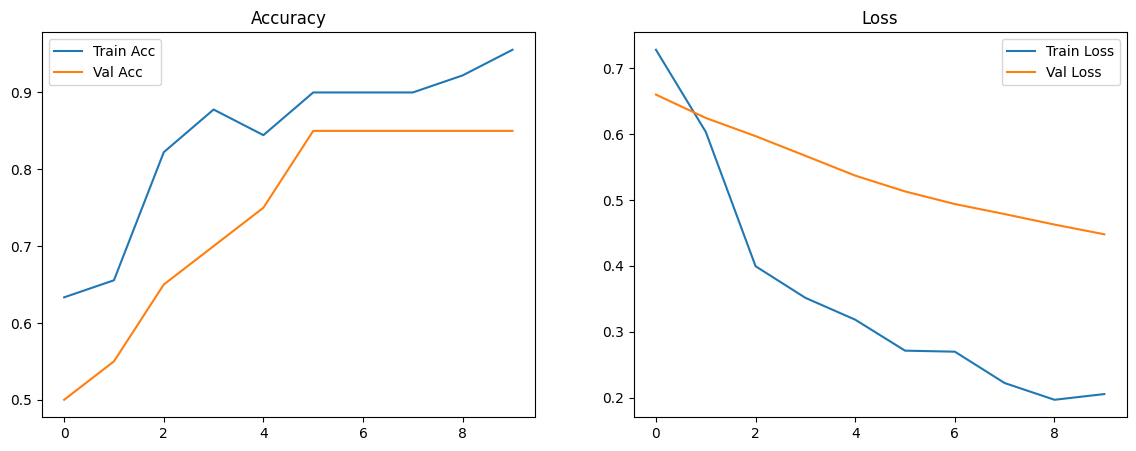

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)

plt.plot(history.history["accuracy"], label="Train Acc")

plt.plot(history.history["val_accuracy"], label="Val Acc")

plt.title("Accuracy")

plt.legend()



plt.subplot(1,2,2)

plt.plot(history.history["loss"], label="Train Loss")

plt.plot(history.history["val_loss"], label="Val Loss")

plt.title("Loss")

plt.legend()


# Grafiklerin ekrana çizdirilmesi
plt.show()


In [ ]:
# =======================
# TEST VERİSİ ÜZERİNDE DEĞERLENDİRME
# =======================

# Eğitim tamamlandıktan sonra model, daha önce hiç görmediği
# test verileri üzerinde değerlendirilir
# Bu aşamada modelin genelleme performansı ölçülür
test_loss, test_acc = model.evaluate(test_data)

# Test doğruluğu ekrana yazdırılır
print("Test Accuracy:", test_acc)

# Test kaybı ekrana yazdırılır
print("Test Loss:", test_loss)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6154 - loss: 0.6554
Test Accuracy: 0.6153846383094788
Test Loss: 0.6554480195045471


In [ ]:
pred = (model.predict(test_data) > 0.5).astype("int32")
true = test_data.classes
print(pred.reshape(-1))
print(true)
print("Accuracy:", (pred.reshape(-1) == true).mean())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.6153846153846154


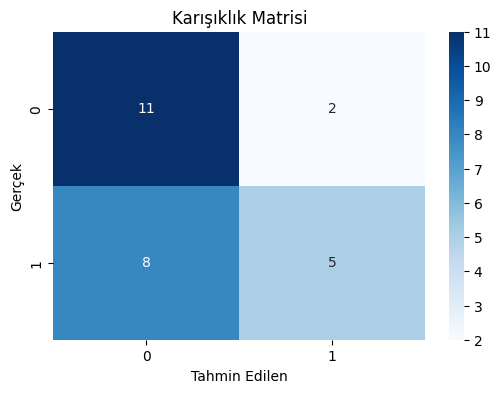

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tahminleri düzleştir (CNN çıktısı (N,1) oluyor)
y_pred = pred.reshape(-1)

# Gerçek sınıflar:
y_true = true

# Karışıklık matrisi
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi")
plt.show()
